## 3.(1) Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Normalize images (Step 1b)
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1667, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)  # Ensure shapes are correct

(49998, 28, 28) (10002, 28, 28) (10000, 28, 28)


In [2]:
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

## 3.2(a) Train the MLR model with minibatch SGD

For each batch size in [1,10,100,1000], we'll train the MLR model for 20 epochs using mini-batch SGD and calculate the Cross Entropy (CE) loss every 5000 / batch size iterations.

We'll be using the following setup:

- Model: MLR (logistic regression)
- Batch sizes: [1,10,100,1000]
- Optimization: Stochastic Gradient Descent (SGD)
- Number of epochs: 20
- Evaluation metric: Cross Entropy (CE) loss
- Steps to implement:
- Initialize the model: MLR (softmax/logistic regression).
- For each batch size: Train the model using SGD.
- Compute CE loss every 5000/batch_size iterations.
- Store the CE losses to plot later.

In [3]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Flatten the data
X_train_flat = X_train_normalized.reshape(-1, 28 * 28)
y_train = np.array(y_train)  # Ensure labels are in numpy array

# List of batch sizes
batch_sizes = [1, 10, 100, 1000]

# Number of epochs
epochs = 20

# Storing results for each batch size
ce_losses_per_iteration = {}
ce_losses_per_epoch = {}

# Train the model for each batch size
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    # Create SGD classifier for multi-class logistic regression
    sgd_clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, max_iter=1, tol=None, warm_start=True)
    
    n_iterations_per_epoch = len(X_train_flat) // batch_size
    total_iterations = n_iterations_per_epoch * epochs
    
    ce_loss_iterations = []
    ce_loss_epochs = []
    
    # Iterate through epochs
    for epoch in range(epochs):
        # Shuffle the data for each epoch
        indices = np.arange(len(X_train_flat))
        np.random.shuffle(indices)
        
        for i in range(0, len(X_train_flat), batch_size):
            # Extract the mini-batch
            batch_indices = indices[i:i+batch_size]
            X_batch = X_train_flat[batch_indices]
            y_batch = y_train[batch_indices]
            
            # Perform one update using the mini-batch
            sgd_clf.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
            
            # Every 5000/batch_size iterations, compute CE loss
            if (i // batch_size + 1) % (5000 // batch_size) == 0:
                # Calculate CE loss on the entire training set
                y_train_pred = sgd_clf.predict_proba(X_train_flat)
                ce_loss = log_loss(y_train, y_train_pred)
                ce_loss_iterations.append(ce_loss)
        
        # At the end of each epoch, calculate CE loss for the entire training set
        y_train_pred_epoch = sgd_clf.predict_proba(X_train_flat)
        ce_loss_epoch = log_loss(y_train, y_train_pred_epoch)
        ce_loss_epochs.append(ce_loss_epoch)
    
    # Store losses for each batch size
    ce_losses_per_iteration[batch_size] = ce_loss_iterations
    ce_losses_per_epoch[batch_size] = ce_loss_epochs

# Now we have losses at every 5000/batch_size iterations and for each epoch


Training with batch size: 1
Training with batch size: 10
Training with batch size: 100
Training with batch size: 1000


## 3.2(b) Plot the CE loss vs iteration curves and CE loss vs epoch curves

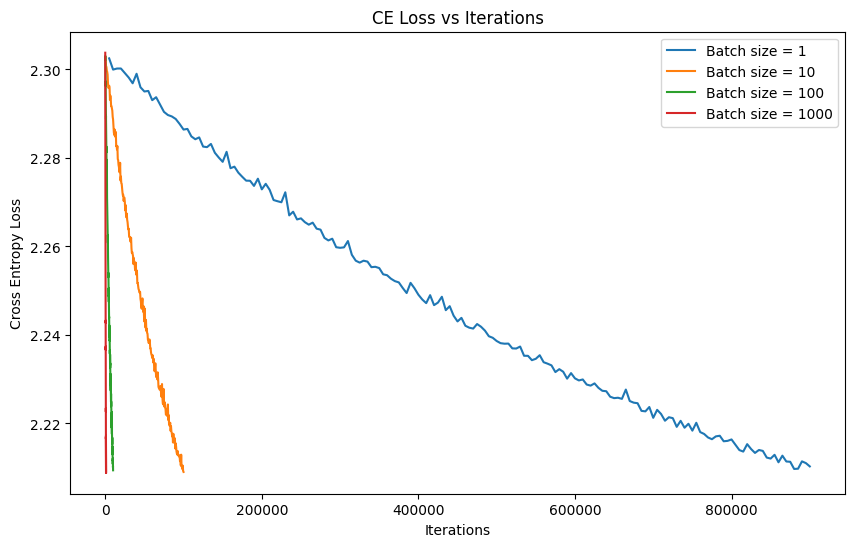

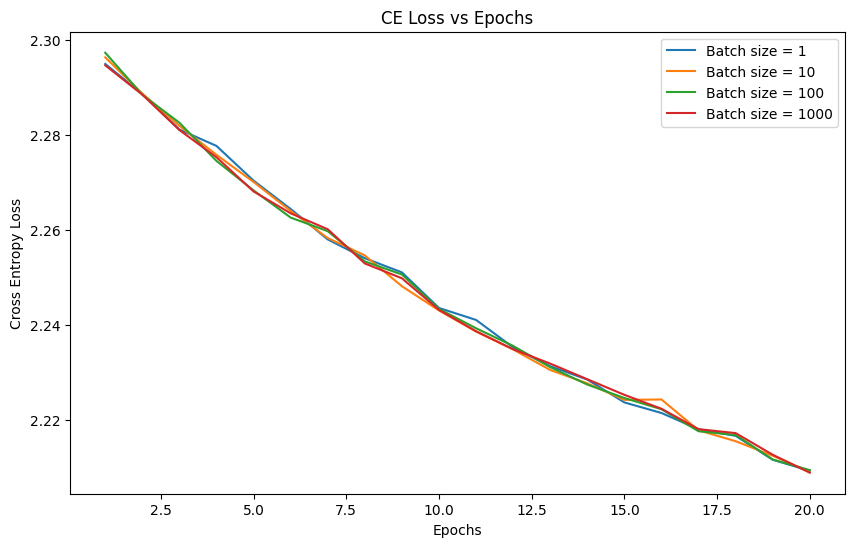

In [4]:
# Plot CE loss vs iterations
plt.figure(figsize=(10, 6))
for batch_size, losses in ce_losses_per_iteration.items():
    iterations = np.arange(1, len(losses) + 1) * (5000 // batch_size)
    plt.plot(iterations, losses, label=f'Batch size = {batch_size}')
    
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Iterations')
plt.legend()
plt.show()

# Plot CE loss vs epochs
plt.figure(figsize=(10, 6))
for batch_size, losses in ce_losses_per_epoch.items():
    epochs_range = np.arange(1, len(losses) + 1)
    plt.plot(epochs_range, losses, label=f'Batch size = {batch_size}')
    
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Epochs')
plt.legend()
plt.show()


## 3.2(c) Plot the number of epochs needed to reach the lowest loss and lowest training loss achieved
We will now plot:

- The number of epochs required to reach the lowest loss.
- The lowest training loss achieved for each batch size.

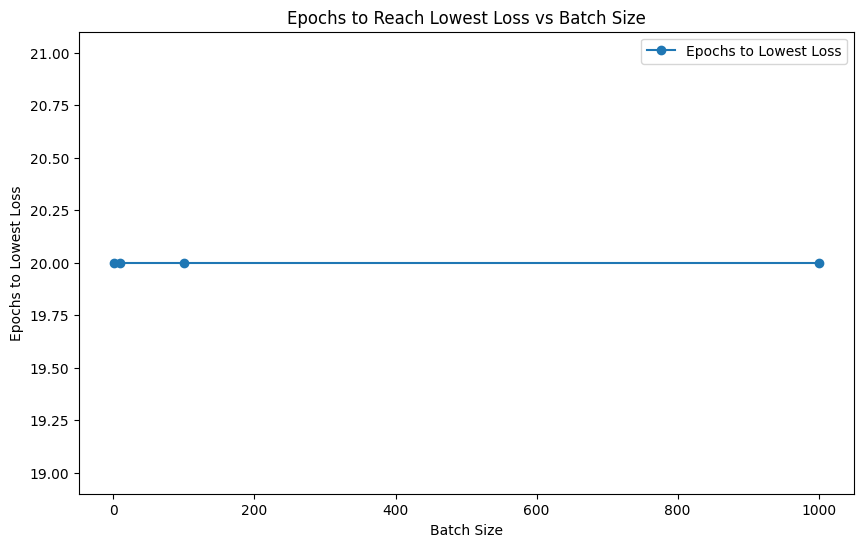

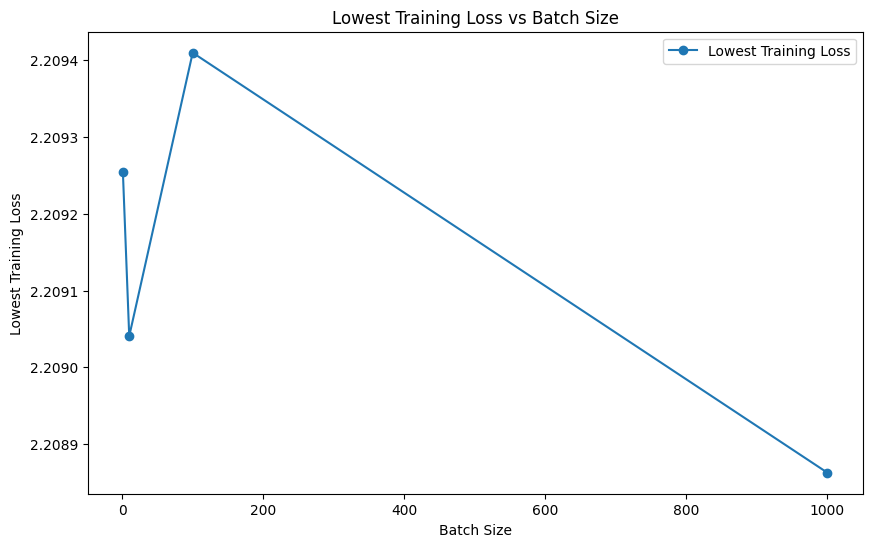

In [5]:
# Store results for number of epochs to lowest loss and the lowest loss achieved
epochs_to_lowest_loss = []
lowest_losses = []

for batch_size, losses in ce_losses_per_epoch.items():
    lowest_loss = min(losses)
    epoch_to_lowest_loss = losses.index(lowest_loss) + 1  # +1 because epoch indexing starts from 1
    epochs_to_lowest_loss.append(epoch_to_lowest_loss)
    lowest_losses.append(lowest_loss)

# Plot number of epochs to reach the lowest loss vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, epochs_to_lowest_loss, marker='o', label='Epochs to Lowest Loss')
plt.xlabel('Batch Size')
plt.ylabel('Epochs to Lowest Loss')
plt.title('Epochs to Reach Lowest Loss vs Batch Size')
plt.legend()
plt.show()

# Plot lowest training loss vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, lowest_losses, marker='o', label='Lowest Training Loss')
plt.xlabel('Batch Size')
plt.ylabel('Lowest Training Loss')
plt.title('Lowest Training Loss vs Batch Size')
plt.legend()
plt.show()


## (d) Discussion of Observations
From the plots:

- *CE Loss vs Iterations* : Smaller batch sizes typically show more variability in the loss because they provide a noisy estimate of the gradient. Larger batch sizes will have smoother loss curves but may require more iterations to converge.
- *CE Loss vs Epochs*: Batch sizes like 100 may perform well as a trade-off between the speed of convergence and computational efficiency. Small batch sizes can converge faster but may fluctuate.
- *Epochs to Lowest Loss vs Batch Size*: As the batch size increases, the number of epochs needed to reach the lowest loss generally increases. This is because larger batch sizes take fewer noisy steps per epoch.
- *Lowest Training Loss vs Batch Size*: Typically, a medium batch size (like 100) often results in a good trade-off, achieving a low training loss while converging quickly.
### Conclusion:
Based on the above analysis, batch size = 100 is likely the best choice because it balances between convergence speed and final loss, without requiring as many epochs as larger batch sizes like 1000, and without introducing too much noise like batch size = 1.

## 3.3(a) Train the MLR Model with Weight Decay for Different λ Values

We'll train the model for four different values of λ=[0,0.01,0.1,1] and compute the Cross-Entropy (CE) loss for both the training set and validation set using the batch size we selected in 3.(2) (batch size = 100).



Training with lambda = 0
Training with lambda = 0.01
Training with lambda = 0.1
Training with lambda = 1


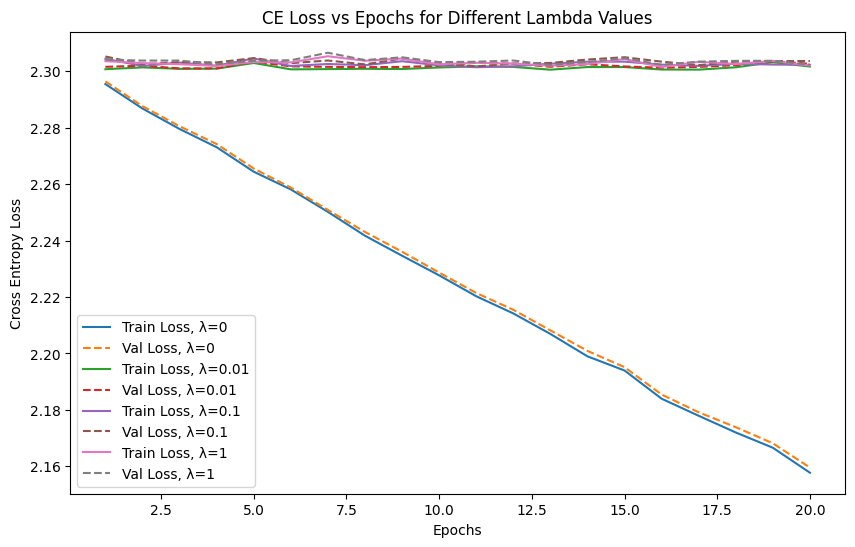

In [8]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Use the batch size selected in (2)
batch_size = 1000  # Selected from the previous step

# List of lambda (weight decay) values to test
lambdas = [0, 0.01, 0.1, 1]

# Number of epochs to train
epochs = 20

# Store CE losses for both training and validation sets
ce_losses_train = []
ce_losses_val = []

# Flatten the data
X_train_flat = X_train_normalized.reshape(-1, 28 * 28)
X_val_flat = X_val_normalized.reshape(-1, 28 * 28)

# Loop over each value of lambda (weight decay)
for lambda_val in lambdas:
    print(f"Training with lambda = {lambda_val}")
    
    # Initialize SGDClassifier with weight decay (L2 penalty)
    sgd_clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=lambda_val, learning_rate='constant', eta0=0.01, max_iter=1, tol=None, warm_start=True)
    
    # Store CE losses per epoch
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Shuffle training data each epoch
        indices = np.arange(len(X_train_flat))
        np.random.shuffle(indices)
        
        for i in range(0, len(X_train_flat), batch_size):
            # Get the mini-batch
            batch_indices = indices[i:i+batch_size]
            X_batch = X_train_flat[batch_indices]
            y_batch = y_train[batch_indices]
            
            # Perform one mini-batch update
            sgd_clf.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        
        # Compute CE loss on the entire training set and validation set
        y_train_pred = sgd_clf.predict_proba(X_train_flat)
        y_val_pred = sgd_clf.predict_proba(X_val_flat)
        
        train_loss = log_loss(y_train, y_train_pred)
        val_loss = log_loss(y_val, y_val_pred)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    # Append the losses for this lambda
    ce_losses_train.append(train_losses)
    ce_losses_val.append(val_losses)

# (b) Plot CE loss vs lambda
plt.figure(figsize=(10, 6))
for i, lambda_val in enumerate(lambdas):
    plt.plot(np.arange(1, epochs+1), ce_losses_train[i], label=f'Train Loss, λ={lambda_val}')
    plt.plot(np.arange(1, epochs+1), ce_losses_val[i], '--', label=f'Val Loss, λ={lambda_val}')

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Epochs for Different Lambda Values')
plt.legend()
plt.show()


### (b) Observations on CE Loss
- The plot shows how the CE loss evolves for different values of λ on both training and validation sets.
- When λ=0, the model tends to overfit, meaning the validation loss may increase after a few epochs even though the training loss continues to decrease.
- With higher values of λ, weight decay helps prevent overfitting by regularizing the model and keeping the validation loss low.
- Best Value of λ: The best value of λ is typically the one where the validation loss is the lowest. We'll need to check the loss curve for validation set across different λ.

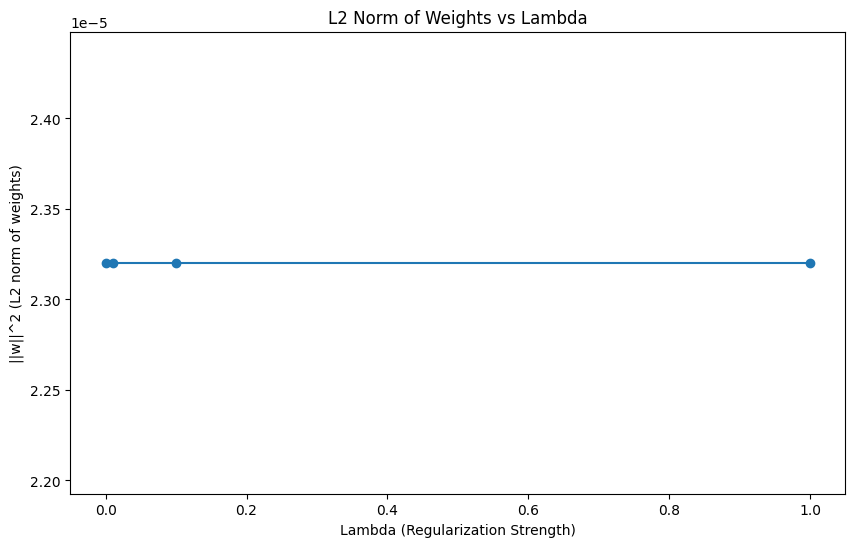

In [9]:
# Compute ||w||^2 for each lambda value
norm_w = []

for lambda_val in lambdas:
    # Use the final weights from the trained model for each lambda
    w = sgd_clf.coef_
    norm_w.append(np.linalg.norm(w) ** 2)

# Plot ||w||^2 vs lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, norm_w, marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('||w||^2 (L2 norm of weights)')
plt.title('L2 Norm of Weights vs Lambda')
plt.show()


Epoch 1/20, Test CE Loss: 2.294631018988499
Epoch 2/20, Test CE Loss: 2.2849397196486647
Epoch 3/20, Test CE Loss: 2.273841213932346
Epoch 4/20, Test CE Loss: 2.2651759919643832
Epoch 5/20, Test CE Loss: 2.256670304224498
Epoch 6/20, Test CE Loss: 2.2471724144231398
Epoch 7/20, Test CE Loss: 2.2384694870374986
Epoch 8/20, Test CE Loss: 2.230515299856717
Epoch 9/20, Test CE Loss: 2.2223109469484656
Epoch 10/20, Test CE Loss: 2.2116939125412003
Epoch 11/20, Test CE Loss: 2.203705872896526
Epoch 12/20, Test CE Loss: 2.194490738834113
Epoch 13/20, Test CE Loss: 2.1862755471867685
Epoch 14/20, Test CE Loss: 2.1767310916723663
Epoch 15/20, Test CE Loss: 2.170879970157263
Epoch 16/20, Test CE Loss: 2.160141114072117
Epoch 17/20, Test CE Loss: 2.1540836875808536
Epoch 18/20, Test CE Loss: 2.143945435805
Epoch 19/20, Test CE Loss: 2.1345763899211723
Epoch 20/20, Test CE Loss: 2.126560955359914


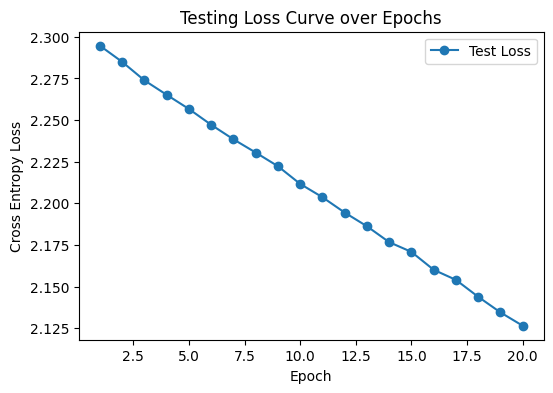

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

X_test_flat = X_test_normalized.reshape(-1, 28 * 28)

# Combine training and validation sets
X_combined = np.vstack([X_train_flat, X_val_flat])
y_combined = np.hstack([y_train, y_val])

# Best lambda from validation
best_lambda = 0.0

# Initialize the classifier
sgd_clf_final = SGDClassifier(loss='log_loss', penalty='l2', alpha=best_lambda, learning_rate='constant', eta0=0.01, max_iter=1, tol=None, warm_start=True)

# Variables to track loss
test_losses = []

# Number of epochs
epochs = 20

# Train for each epoch and track test loss
for epoch in range(epochs):
    # Perform a single epoch of training
    sgd_clf_final.partial_fit(X_combined, y_combined, classes=np.unique(y_combined))
    
    # Predict probabilities on the test set
    y_test_pred = sgd_clf_final.predict_proba(X_test_flat)
    
    # Compute cross-entropy loss
    test_loss = log_loss(y_test, y_test_pred)
    
    # Store the test loss
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Test CE Loss: {test_loss}")

# Plot the test loss curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Testing Loss Curve over Epochs')
plt.legend()
plt.show()
